# Lab 8 - Adv Prompt Engineering

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd

load_dotenv()  # 敏感信息不能明文展示
api_key = os.getenv('OPENAI_API_KEY')

from openai import OpenAI

client = OpenAI(
            api_key=api_key,
            base_url="https://api.aaaapi.com/v1")

# 1 多模态

大模型的一个重要发展方向是多模态，即输入形式不局限于文字，包括文字、语音、视频等

## 1.1 图像理解

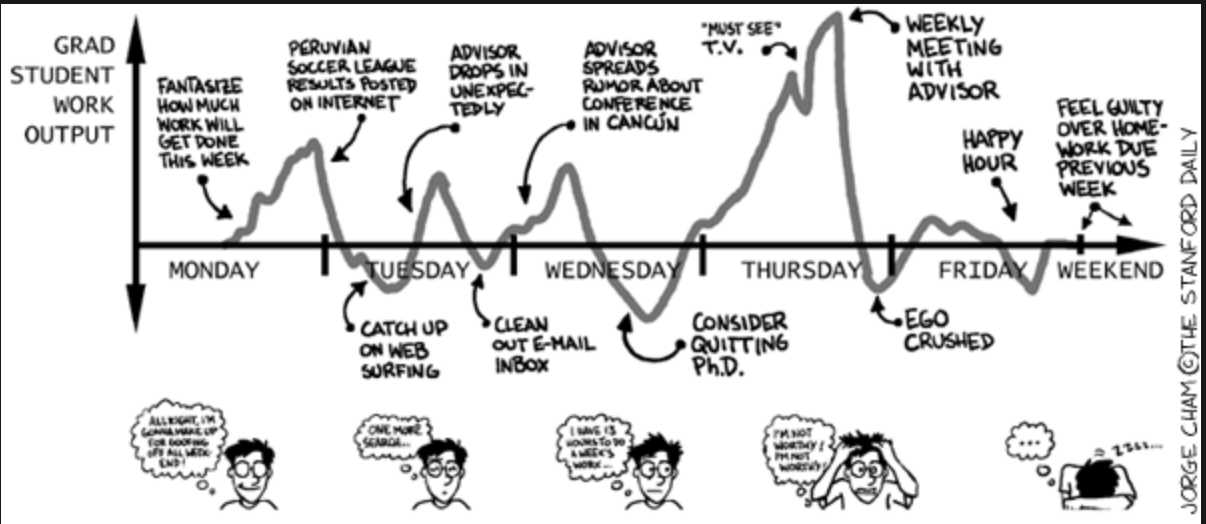

In [14]:
# Display the image
file_path = "../data/test_img.png"
from IPython.display import Image
Image(filename=file_path)


In [16]:
import base64
# Read and encode the image
local_img_payload = "data:image/png;base64," + base64.b64encode(open(file_path, "rb").read()).decode('utf-8')

In [17]:

# Create vision completion
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text", 
                    "text": "Why is this comic funny? Please explain the humor in chinese"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": local_img_payload
                    }
                }
            ]
        }
    ],
    max_tokens=300  # 控制输出长度
)

print(response.choices[0].message.content)

这个漫画通过夸张和讽刺描绘了研究生一周的工作效率变化，以产生幽默效果。图中曲线表示工作产出，随着一周的进展，曲线不断变化，反映出各种干扰因素。

1. **开头充满幻想**：周一充满干劲，幻想本周会完成很多工作，但很快就被各种琐事干扰，如互联网浏览、意外拜访等。

2. **干扰频繁**：如秘鲁足球联赛结果、没必要却“必须看”的电视节目等，反映出拖延和分心的常见现象。

3. **导师的影响**：漫画中导师偏偏在关键时刻出现，并传播让人分心的消息，这种戏剧性的逆转增强了幽默感。

4. **逐渐崩溃**：到周中，存在放弃读博的挣扎，继续到周五的“自尊心受到打击”，使人忍俊不禁，体现了研究生的心理波动。

5. **负面循环**：随着周末到来，角色感到内疚并最终陷入疲惫，展示出一个周期性怪圈，有趣地勾画了研究生的艰辛。

这种幽默来源于对生活中普遍情况的夸大，


**TODO:** 试试破解Google的机器人防护，哪些图片里有楼梯？

任务：修改instruction_prompt，使得正确返回下述结果

- puzzle-1 1
- puzzle-2 1
- puzzle-3 0

In [24]:
import base64
files = [f'puzzle-{x}.png' for x in range(1,4)]
payload = {x.split('.')[0]: "data:image/gif;base64," + base64.b64encode(open(f'../data/{x}', "rb").read()).decode('utf-8') for x in files}

In [25]:
instruction_prompt = """
# Workflow
1. 如果图中有楼梯，flag 1，否则为0。
2. 必须明确找到一个楼梯，而不是“像”或者“类似”

# 输出格式
以json格式返回
"""  

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text", 
                    "text": instruction_prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": payload['puzzle-1']
                    }
                }
            ]
        }
    ],
    response_format={"type": "json_object"}  # 返回json
)
print(response.choices[0].message.content)  

{
  "flag": 1
}


## 1.2 语音理解

方案1: Speech To Text(ASR) -> LLM

方案2: LLM Audio 端到端直接输出（需要授权）

In [26]:
from markitdown import MarkItDown

md = MarkItDown().convert('../data/preamble.wav')
print(md.text_content)

### Audio Transcript:
we the people of the United States in order to form a more perfect union establish justice and sure domestic tranquility provide for the common defense promote the general welfare and secure the blessings of liberty to ourselves and our posterity do ordain and establish this constitution for the United States of America


In [27]:
response = client.chat.completions.create(
    model="gpt-4o",  
    messages=[
        {"role": "user", "content": f" where is the content from?：{md.text_content}"}
    ]
)
print(response.choices[0].message.content)

The content in the audio transcript you provided is the **Preamble to the Constitution of the United States**. It introduces the U.S. Constitution and outlines the fundamental purposes and guiding principles of the document. It was written in 1787 during the Constitutional Convention and serves as the opening statement to the nation's founding legal framework.


# 2. 循证迭代

在不改变基座模型的前提下，通过提示词可以实质性提高模型的表现。

因为提示词是自然语言构建的，因此提示词给了人们一个通过自然语言编程来生产app的机会。在我看来这是革命性的进展。

在上一讲中，我们已经介绍了如何编写第一个user prompt，这只是cold start，更多的工作是要在后续的工作中不断发现bad case，并且通过提示词去修复。这是目前我所了解的，最靠谱的提示词迭代方式。



## 2.1 任务介绍
一个服务团队要检查其员工是否通知学生补课。下述两个条件是他们的“质检规则”

    - 通过企业微信发送了补课消息，就算通知
    - 进行了电话外呼（即使没有接通），也算通知

员工可能在当天进行了上课提醒，这不是补课通知。


## 2.2数据集
`classification_sample.csv`有3列，第一列是`text`，代表企微聊天记录；第二列是`callout`，代表外呼次数；第三列是`flag`，代表业务团队专家判断的是否通过了“质检”。

## 2.3 任务
利用提示词，训练一个模型，能够自动判断员工是否通过了“质检”。

In [28]:
data = pd.read_csv("../data/classification_sample.csv")

In [29]:
def classify_with_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_format={"type": "json_object"}  # 返回json格式，以免解析问题
    )
    return response.choices[0].message.content

In [39]:
def _construct_prompt(text, callout):
    return f"""
    ```
    你是一个文本之间元，请判断以下对话是否是关于补课的对话。补课的含义是学生先前有缺课，LA通过企业微信去提醒家长补上之前的课程。
    如果是补课相关的对话，输出1，否则输出0。
    
    你要检查的沟通记录是
    {text}

    对该用户的外呼次数是{callout}。如果外呼次数大于1，则flag为1，否则为0

    你的输出结果是一个json{{"flag": 0/1}}
    ```
    """

In [40]:
# 创建一个空列表来存储预测结果
predicted_flags = []

# 遍历数据集并获取预测

for index, row in data.iterrows():
    flag = classify_with_llm(_construct_prompt(row["text"], row["callout"]))
    predicted_flags.append(flag)

# 将预测结果添加到数据集中
data["predicted_flag"] = predicted_flags



In [33]:
data["predicted_flag"].value_counts()

predicted_flag
{"flag": 1}            36
{"flag": 0}             8
{\n  "flag": 0\n}       2
{\n  "flag": 1\n}       2
{\n    "flag": 1\n}     1
Name: count, dtype: int64

In [41]:
from sklearn.metrics import classification_report
import json

# 将json字符串转换为数值
data['predicted_flag_numeric'] = data['predicted_flag'].apply(lambda x: json.loads(x)['flag'])

# 计算F1分数
perf = classification_report(data['flag'], data['predicted_flag_numeric'])
print(perf)


              precision    recall  f1-score   support

           0       0.92      0.52      0.67        23
           1       0.69      0.96      0.81        26

    accuracy                           0.76        49
   macro avg       0.81      0.74      0.74        49
weighted avg       0.80      0.76      0.74        49



# 2.2 迭代

找到flag=1但是predicted_flag=0的case，或者flag=0但是predicted_flag=1的case。

分析这些case，看如何优化你的提示词。



In [35]:


# 找出 flag=0 但 predicted_flag=1 的案例
false_negatives = data[(data['flag'] == 0) & (data['predicted_flag_numeric'] == 1)]

print("False Negatives (flag=1 but predicted as 0):")
print("-" * 80)
for idx, row in false_negatives.iterrows():
    print(f"Case {idx}:")
    print(f"Text:\n{row['text']}")
    print(f"Callout: {row['callout']}")
    print("-" * 80)


False Negatives (flag=1 but predicted as 0):
--------------------------------------------------------------------------------
Case 2:
Text:
2024-05-25
*企微消息*
LA:再坚持一下，ἳ1播种和收获，本就在不同的季节ἳ3
今天周六，小懿宝贝要学习《有个小马虎》，2024-05-2518:20:00准时进入ἳ7

惊喜藏在努力里ὠe周末也别忘记巩固【火花秘籍】和【小老师视频】哦~
用户:[OK]
LA:[愉快]
用户:老师你好，小懿去补牙还没那么快，今天课请个假吧[抱拳][抱拳][抱拳]
用户:[抱拳][抱拳]
LA:[爱心][爱心]
Callout: 0
--------------------------------------------------------------------------------
Case 5:
Text:
2024-05-25
*企微消息*
LA:mia今天要学习《半壁江山（基础）》，2024-05-2518:50:00辛苦您提醒宝贝准时进入✨

课后辛苦督促宝贝完成【火花秘籍】和【火花秘籍】授课老师会批改~
LA:又到了黄金周末啦，近期专题难度增加，周末是参加免费专题复习课的黄金时期。
ὄ7ὄ7ὄ7每天具体的场次有：
8：00、9：00、10:00、11:00、12：00、13：00、14：00、15:00、16：00、17:00、18：00、19:00、20:00。
Callout: 0
--------------------------------------------------------------------------------
Case 6:
Text:
2024-05-25
*企微消息*
LA:7点嘉年华复习课可以参加哟，就在学生端右上角【嘉年华】就可以加入哟。8点也行
明天的所有整点时间也可以参加
Callout: 0
--------------------------------------------------------------------------------
Case 12:
Text:
2024-05-25
*企微消息*
LA:今

在优化时，最好遵循这样的实践：

    1. 首先验证修改后的提示词是否正确解决这个case
    2. 重跑所有case，看看其他case是否有变化。如果其他case的效果恶化严重，那么需要放弃这个修改


考虑你可以使用的工具：

    - 使用KIMI 模版来结构化输出业务判定规则，具体说明什么叫补课
    - 提供一些case来向大模型“解释”你的判定规则



In [36]:
def recheck_case(instruction,case_id):
    # Get the specific case
    case = data.loc[case_id]
    
    # Prepare the prompt
    prompt = f"""
{instruction}
对话内容：
{case['text']}"""

    # Call the model
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    
    # Get the prediction
    prediction = int(response.choices[0].message.content.strip())
    
    # Print results
    print(f"Original Text:\n{case['text']}\n")
    print(f"True Label: {case['flag']}")
    print(f"Original Prediction: {case['predicted_flag_numeric']}")
    print(f"New Prediction: {prediction}")

# Example usage:
# recheck_case(0)  # Replace with any case ID you want to check



In [38]:
instruction = """
你是一个文本之间元，请判断以下对话是否是关于补课的对话。补课的含义是学生先前有缺课，LA通过企业微信去提醒家长补上之前的课程。
如果是补课相关的对话，输出1，否则输出0。
只需要输出数字，不需要其他解释。
"""
recheck_case(instruction, 5)

Original Text:
2024-05-25
*企微消息*
LA:mia今天要学习《半壁江山（基础）》，2024-05-2518:50:00辛苦您提醒宝贝准时进入✨

课后辛苦督促宝贝完成【火花秘籍】和【火花秘籍】授课老师会批改~
LA:又到了黄金周末啦，近期专题难度增加，周末是参加免费专题复习课的黄金时期。
ὄ7ὄ7ὄ7每天具体的场次有：
8：00、9：00、10:00、11:00、12：00、13：00、14：00、15:00、16：00、17:00、18：00、19:00、20:00。

True Label: 0
Original Prediction: 1
New Prediction: 0
